Inference into the distribution of BigBird-CT model generated embedding cosine similarities

The BigBird-CT model which has been trained on the full dataset is used here, to replicate that an end product model might be trained and then used for inference on the full dataset.

N.B. Strongly recommended to run this Notebook on a GPU

In [ ]:
from pathlib import Path
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np


# load train.pkl
train_path = Path.cwd().parent.joinpath('data/processed/train.pkl')
train = pd.read_pickle(train_path)

# load test_unlabelled.pkl
test_path = Path.cwd().parent.joinpath('data/interim/test_unlabelled.pkl')
test = pd.read_pickle(test_path)

# concatenate train and test data
fulldata = pd.concat([train, test])

# load our fine-tuned BigBird-CT with in-batch negatives model which has been trained on the full dataset
model_fulldata_bigbird_ct_path = Path.cwd().parent.joinpath('models/FULLDATA_bigbird-ct')
model = SentenceTransformer(model_fulldata_bigbird_ct_path)

sentences = fulldata['Concatenated'].tolist()
codes = fulldata['ModuleCode'].tolist()

# get document embeddings for our testing set modules
embeddings = model.encode(sentences,
                          batch_size = 16,
                          show_progress_bar = True)

Batches:   0%|          | 0/269 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 696 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


In [ ]:
# find the cosine similarity matrix for the embeddings
cos_sim = util.cos_sim(embeddings, embeddings)

# add all pairs to a list, with their cosine similarity score, EXCLUDING self-similarities
cosine_similarities = []
for i in range(len(cos_sim) - 1):
    for j in range(i + 1, len(cos_sim)):
        cosine_similarities.append(cos_sim[i][j])

As a final assessment of the generated embeddings, we look at the distribution of cosine similarities on the full dataset, for this fully fitted model.

In [ ]:
# get list of cosine similarities
all_similarities = np.array(cosine_similarities)

lower_quartile = np.quantile(all_similarities, q = 0.25)
upper_quartile = np.quantile(all_similarities, q = 0.75)

cos_sim_min = np.min(all_similarities)
cos_sim_max = np.max(all_similarities)

# summary statistics for the distribution of cosine similarities
print(f'Mean Cosine Similarity: {np.mean(all_similarities)}')
print(f'Minimum Cosine Similarity: {cos_sim_min}')
print(f'Lower Quartile Cosine Similarity: {lower_quartile}')
print(f'Median Cosine Similarity: {np.median(all_similarities)}')
print(f'Upper Quartile Cosine Similarity: {upper_quartile}')
print(f'Maximum Cosine Similarity: {cos_sim_max}')

interquartile_range = upper_quartile - lower_quartile
full_range = cos_sim_max - cos_sim_min
range_ratio = interquartile_range / full_range

print(f'Interquartile range to full range ratio: {range_ratio}')

all_similarities = pd.Series(all_similarities)

Mean Cosine Similarity: 0.36449846625328064
Minimum Cosine Similarity: -0.2952098548412323
Lower Quartile Cosine Similarity: 0.2923612594604492
Median Cosine Similarity: 0.35417717695236206
Upper Quartile Cosine Similarity: 0.4270307123661041
Maximum Cosine Similarity: 1.0000004768371582
Interquartile range to full range ratio: 0.1039749656972307


<Axes: >

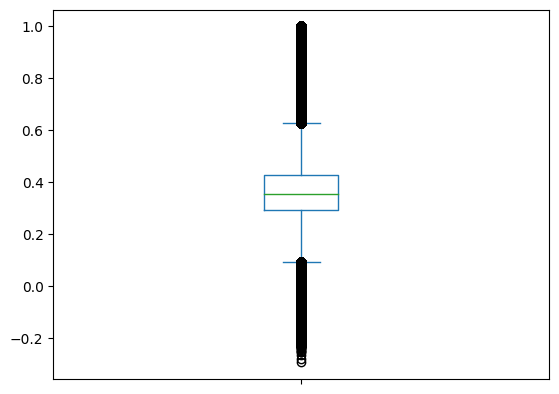

In [ ]:
# boxplot of cosine similarities
display(all_similarities.plot.box())

<Axes: >

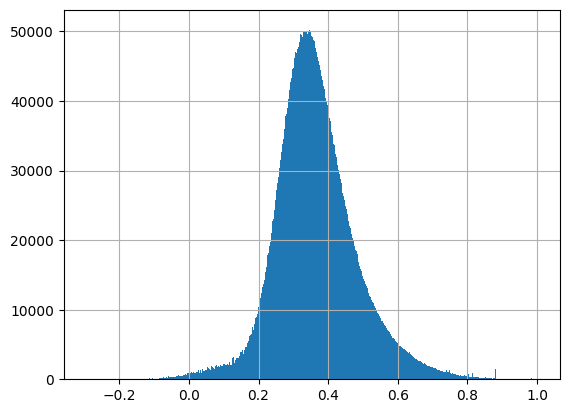

In [ ]:
# histogram of cosine similarities
display(all_similarities.hist(bins = 1000))

We see that the distribution of cosine similarities is approximately symmetric. The range of values is approximately $[-0.3, 1.0]$. It has median and mean approximately $0.36$, with high kurtosis; its interquartile range only spans approximately $10\%$ of the full range of values. Thus, the majority of cosine similarities are approximately $0.36$, and we might say that a notably dissimilar or similar comparison, on unseen data, has a cosine similarity outside of the interval $[0.29,0.43]$ . Alternatively, looking at the boxplot, you might say that the given outliers are examples of notably similar or dissimilar comparisons, in which case you might reference the interval $[0.1,0.6]$ to this end. This simple statistical analysis of the cosine similarity distribution provides ideas for how you might classify these similarities into interpretable bins.